# Text generation with an RNN

In this project, we demonstrates how to generate text using a character-based RNN. We use the Mobi Dick text data. Given a sequence of characters from this data ("Goldsmit"), we train a model to predict the next character in the sequence ("h"). Longer sequences of text can be generated by calling the model repeatedly.

## Setup

### Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time
import pandas as pd

### Import the Moby Dick dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks//deepl-next-char-forecast___2')

!ls

MobyDick.txt  sequence_generation_GRU.ipynb


### Read the data

In [ ]:
# Read, then decode for py2 compat.
text = open("MobyDick.txt", 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1260671 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

﻿The Project Gutenberg eBook of Moby-Dick; or The Whale, by Herman Melville

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy i


We remove the table of contents and other data that we do not need to train the model. This means that we start from "EXTRACTS"

In [ ]:
print(text[7524:9000])

  It will be seen that this mere painstaking burrower and grub-worm of
  a poor devil of a Sub-Sub appears to have gone through the long
  Vaticans and street-stalls of the earth, picking up whatever random
  allusions to whales he could anyways find in any book whatsoever,
  sacred or profane. Therefore you must not, in every case at least,
  take the higgledy-piggledy whale statements, however authentic, in
  these extracts, for veritable gospel cetology. Far from it. As
  touching the ancient authors generally, as well as the poets here
  appearing, these extracts are solely valuable or entertaining, as
  affording a glancing bird’s eye view of what has been promiscuously
  said, thought, fancied, and sung of Leviathan, by many nations and
  generations, including our own.

  So fare thee well, poor devil of a Sub-Sub, whose commentator I am.
  Thou belongest to that hopeless, sallow tribe which no wine of this
  world will ever warm; and for whom even Pale Sherry would be too
  ros

In [ ]:
text = text[7524:]

In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

95 unique characters


## Process the text

### Vectorize & One-hot encoding the text

Before training, we convert the strings to a numerical representation. 

<!-- The `tf.keras.layers.StringLookup` layer can convert each character into a numeric ID. It just needs the text to be split into tokens first. -->

create `tf.keras.layers.StringLookup` layer:

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. 

The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?


### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1253147,), dtype=int64, numpy=array([ 3,  3, 38, ...,  1,  2,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
ids_dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [ ]:
ids_dataset.take(0)

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [ ]:
for ids in ids_dataset.take(15):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

 
 
I
t
 
w
i
l
l
 
b
e
 
s
e


In [ ]:
seq_length = 100

The `batch` method lets us easily convert these individual characters to sequences of the desired size.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b' ' b' ' b'I' b't' b' ' b'w' b'i' b'l' b'l' b' ' b'b' b'e' b' ' b's'
 b'e' b'e' b'n' b' ' b't' b'h' b'a' b't' b' ' b't' b'h' b'i' b's' b' '
 b'm' b'e' b'r' b'e' b' ' b'p' b'a' b'i' b'n' b's' b't' b'a' b'k' b'i'
 b'n' b'g' b' ' b'b' b'u' b'r' b'r' b'o' b'w' b'e' b'r' b' ' b'a' b'n'
 b'd' b' ' b'g' b'r' b'u' b'b' b'-' b'w' b'o' b'r' b'm' b' ' b'o' b'f'
 b'\r' b'\n' b' ' b' ' b'a' b' ' b'p' b'o' b'o' b'r' b' ' b'd' b'e' b'v'
 b'i' b'l' b' ' b'o' b'f' b' ' b'a' b' ' b'S' b'u' b'b' b'-' b'S' b'u'
 b'b' b' ' b'a'], shape=(101,), dtype=string)


It's easier to see what this is doing if we join the tokens back into strings:

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'  It will be seen that this mere painstaking burrower and grub-worm of\r\n  a poor devil of a Sub-Sub a'
b'ppears to have gone through the long\r\n  Vaticans and street-stalls of the earth, picking up whatever '
b'random\r\n  allusions to whales he could anyways find in any book whatsoever,\r\n  sacred or profane. The'
b'refore you must not, in every case at least,\r\n  take the higgledy-piggledy whale statements, however '
b'authentic, in\r\n  these extracts, for veritable gospel cetology. Far from it. As\r\n  touching the ancie'


For training we'll need a dataset of `(input, label)` pairs. Where `input` and 
`label` are sequences. At each time step the input is the current character and the label is the next character. 

Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each timestep:

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'  It will be seen that this mere painstaking burrower and grub-worm of\r\n  a poor devil of a Sub-Sub '
Target: b' It will be seen that this mere painstaking burrower and grub-worm of\r\n  a poor devil of a Sub-Sub a'


### Create training batches

You used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, you need to shuffle the data and pack it into batches.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Build The Model

This model has three layers:



In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## Try the model

Now we run the model to see that it behaves as expected.

We check the shape of the output:

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 96) # (batch_size, sequence_length, vocab_size)


Above, the example in the sequence length of the input is `100` but the model can be run on inputs of any length:

In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  24576     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  98400     
                                                                 
Total params: 4,061,280
Trainable params: 4,061,280
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [ ]:
sampled_indices

array([ 9, 11, 84, 84, 62, 51, 24, 27, 68, 12, 54, 44, 17, 65, 52, 56, 44,
       33, 54, 36, 11, 49, 78, 40, 12,  4, 74, 62, 69, 59, 32, 78, 10,  1,
       45,  7, 34, 77, 48, 33, 11, 94, 75, 54, 94, 89, 88, 94, 39, 72, 73,
       57, 94, 27, 59, 25, 72, 49, 40, 54, 77, 75, 79, 70, 30, 29, 31, 76,
       48, 37, 93, 62, 91, 47, 11, 42, 58, 22, 45, 71,  1, 27, 63, 32, 25,
        2, 77, 44, 30, 40, 71, 36, 76,  7, 45, 54, 26, 84, 16, 91])

Decode these to see the text predicted by this untrained model:

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ure it again until the whale is\r\nfairly captured and a corpse.\r\n\r\nConsider, now, how it must be in t'

Next Char Predictions:
 b"')zzdV7:j*YO0gW[ODYG)TtK*!pdkaCt(\nP%EsSD)\xe2\x80\x9cqY\xe2\x80\x9c\xc3\xa9\xc3\xa8\xe2\x80\x9cJno]\xe2\x80\x9c:a8nTKYsqulA?BrSH\xe2\x80\x99d\xe2\x80\x94R)M_5Pm\n:eC8\rsOAKmGr%PY9z/\xe2\x80\x94"


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 96)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.5647645, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

96.03997

In [ ]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_gru'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

In [ ]:
EPOCHS = 50

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/50
193/193 [==============================] - 13s 53ms/step - loss: 2.6114
Epoch 2/50
193/193 [==============================] - 11s 53ms/step - loss: 1.9889
Epoch 3/50
193/193 [==============================] - 14s 55ms/step - loss: 1.7366
Epoch 4/50
193/193 [==============================] - 12s 55ms/step - loss: 1.5768
Epoch 5/50
193/193 [==============================] - 12s 56ms/step - loss: 1.4759
Epoch 6/50
193/193 [==============================] - 12s 57ms/step - loss: 1.4036
Epoch 7/50
193/193 [==============================] - 12s 57ms/step - loss: 1.3481
Epoch 8/50
193/193 [==============================] - 12s 56ms/step - loss: 1.2984
Epoch 9/50
193/193 [==============================] - 12s 56ms/step - loss: 1.2528
Epoch 10/50
193/193 [==============================] - 12s 55ms/step - loss: 1.2094
Epoch 11/50
193/193 [==============================] - 12s 56ms/step - loss: 1.1654
Epoch 12/50
193/193 [==============================] - 12s 57ms/step - loss: 1.1197
E

## Generate text

The simplest way to generate text with this model is to run it in a loop, and keep track of the model's internal state as you execute it.

![To generate text the model's output is fed back to the input](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/text_generation_sampling.png?raw=1)

Each time we call the model we pass in some text and an internal state. The model returns a prediction for the next character and its new state. Pass the prediction and state back in to continue generating text.


The following makes a single step prediction:

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Running it in a loop to generate some text. Looking at the generated text, we see the model knows when to capitalize, make paragraphs and imitates a MobyDick-like writing vocabulary. With the small number of training epochs, it is still learning to form coherent sentences.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['Gabriel '])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Gabriel called Ramacely forward as cast
long chucks; he lovew that descriet for good-box with blanket in his tambourine whiteness may
over any one but of wrickly to help himself for the same example of the
Pequod; and then again ruminated the roar of two long
rolling boat; when without at all been accomplished with a
burning flower of the voyage must be overboard in an inhabitable,
below in concert with business to all his hat.

“What will not broad and flow up by the lines attached with
ut like a preceut of our cabin. There is Nantucket, the other end considerations
much imminently puflished. Rost of things are castingly envealogs. True, or
some endress stuff, when Linged her boats, struck by
way of magic in his habitades? To whom all thinks I thought this firm from
God and Yojo is in some way, but soon has been a great chumped
boat.

Soon howled a grey for Spermai, Stretch was perched at the preferal
furnishing weight he (didest those see that I was thus to be found in repos 

______

Below the model generates 5 outputs in about the same time it took to generate 1 above. 

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['Gabriel ', 'Gabriel ', 'Gabriel ', 'Gabriel ', 'Gabriel '])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b'Gabriel was but to spring. Well, for the bost-decord\r\nappallingly taking near so long after his side. The hunting\r\ncaptain, how done to lower; ye good toes.\xe2\x80\x9d\r\n\r\n\xe2\x80\x9cI two seeks, and gentlemanly repeated, still hardly\r\nis this? Are the grey dinger\xe2\x80\x99s bag, and do ye see, the old sea-captain snutch with\r\nthe Moss drued again; she heaved her first. A brawny,\r\nsustain, by reason or not, cushing the hugest old man at the foot, those\r\nbetween muffains and bounders in the Polar Side. The try-works has to go\r\nbattle their zones. On more and mortal seamen, as a headed\r\nbison; sir. The body is, it being calling all hands\xe2\x80\x94to close the whales find the rocks of\r\ntold-meaness; he recomments sank in hand, so as to bring his harpoon grow. And here\xe2\x80\x99s theee; true, and\r\nputting monots of news mortals of grace against a tinker ship.\r\n\r\nAt such things upon the might seemed all revealed his vice-bench\r\nabove to lan

## Export the generator

This single-step model can easily be saved and restored, allowing us to use it anywhere a `tf.saved_model` is accepted.

In [ ]:
tf.saved_model.save(one_step_model, 'one_step_gru')
one_step_reloaded = tf.saved_model.load('one_step_gru')

In [ ]:
states = None
next_char = tf.constant(['Gabriel '])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

Gabriel called _clinctuals, and The four
apprehension of ships than the mate’s grief, as I have been a
cre


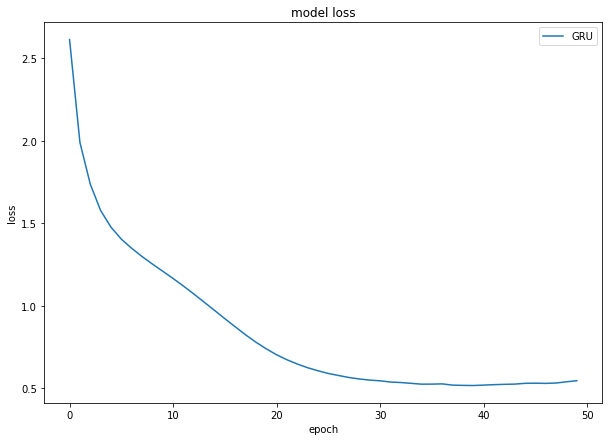

In [ ]:
# history.history.keys()
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
plt.plot(history.history['loss'], label = "GRU")
plt.title('model loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch');

### Test the model.

In [ ]:
original_test_file = ['Biographical',
'Wheelbarrow',
'Nightgown',
'Counterpane',
'Christmas',
'Squires',
'Specksnyder',
'Forecastle',
'Affidavit',
'Hyena',
'Monstrous',
'Town-Ho',
'Massacre',
'Funeral',
'Battering-Ram']


In [ ]:
gru_pred = []
original_test_file_excluding_last_two_chars = [] 
states = None


for i in original_test_file:
    
    original_test_file_excluding_last_two_chars.append(i[:-2])

    next_char = tf.constant([i[:-2]])
    result = [next_char]

    for j in range(2):

        next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
        result.append(next_char)   

    gru_pred.append( tf.strings.join(result)[0].numpy().decode("utf-8") ) 

In [ ]:
gru_pred

['Biographical',
 'Wheelbarrow',
 'Nightgo, ',
 'Counterpane',
 'Christmat',
 'Squir,\r',
 'Specksnydly',
 'Forecast l',
 'Affidavis',
 'Hyers',
 'Monstrone',
 'Town-ya',
 'Massache',
 'Funeran',
 'Battering-R\r\n']

# MLP

## Build The Model

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModelMLP(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)
    # tf.keras.layers.add(Dense(vocab_size))
    # self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    # if states is None:
    #   states = self.gru.get_initial_state(x)
    # x, states = self.gru(x, initial_state = states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
# # from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Dense, LSTM

# # # Define the Keras model
# # model = Sequential()
# # model.add(Embedding(vocab_size, embedding_dim))
# # model.add(LSTM(rnn_units))
# # model.add(Dense(vocab_size))

In [ ]:
model = MyModelMLP(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## Try the model

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 96) # (batch_size, sequence_length, vocab_size)


In [ ]:
# model.summary()

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [ ]:
sampled_indices

array([ 7, 94, 25, 40, 28, 80, 71, 72, 55, 28, 32, 21, 46, 55, 30, 90, 53,
       37, 40,  0,  2, 74, 84, 88, 71, 22, 16, 29, 87, 20, 51, 72, 88, 34,
       20, 11, 46, 89,  1, 31, 94, 82, 13, 56, 69, 54, 71, 48, 11, 56, 85,
       66, 12, 52, 86, 74, 26,  1, 12, 82, 92, 77, 85, 82,  2, 15, 71, 13,
       57, 94, 20, 93, 39, 49, 46, 62, 55, 72, 26, 11, 70, 23, 61, 38, 64,
       17, 74, 26, 11, 13, 33, 88, 46, 64, 75, 95, 85, 37, 28, 19])

Decode these to see the text predicted by this untrained model:

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'h, and viciously spat round her on\r\nall sides; then the rushing Pequod, freighted with savages, and '

Next Char Predictions:
 b'%\xe2\x80\x9c8K;vmnZ;C4QZA\xc5\x93XHK[UNK]\rpz\xc3\xa8m5/?\xc3\xa63Vn\xc3\xa8E3)Q\xc3\xa9\nB\xe2\x80\x9cx,[kYmS)[\xc2\xa3h*W\xc3\xa2p9\n*x\xe2\x80\x98s\xc2\xa3x\r.m,]\xe2\x80\x9c3\xe2\x80\x99JTQdZn9)l6cIf0p9),D\xc3\xa8Qfq\xe2\x80\x9d\xc2\xa3H;2'


## Train the model

### Attach an optimizer, and a loss function

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 96)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.5650387, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

96.06631

In [ ]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_mlp'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

In [ ]:
EPOCHS = 50

In [ ]:
history_mlp = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/50
193/193 [==============================] - 2s 5ms/step - loss: 3.1211
Epoch 2/50
193/193 [==============================] - 2s 4ms/step - loss: 2.4766
Epoch 3/50
193/193 [==============================] - 3s 8ms/step - loss: 2.4507
Epoch 4/50
193/193 [==============================] - 3s 5ms/step - loss: 2.4433
Epoch 5/50
193/193 [==============================] - 2s 5ms/step - loss: 2.4401
Epoch 6/50
193/193 [==============================] - 2s 5ms/step - loss: 2.4380
Epoch 7/50
193/193 [==============================] - 2s 4ms/step - loss: 2.4370
Epoch 8/50
193/193 [==============================] - 2s 4ms/step - loss: 2.4363
Epoch 9/50
193/193 [==============================] - 2s 4ms/step - loss: 2.4360
Epoch 10/50
193/193 [==============================] - 2s 4ms/step - loss: 2.4354
Epoch 11/50
193/193 [==============================] - 2s 5ms/step - loss: 2.4349
Epoch 12/50
193/193 [==============================] - 2s 5ms/step - loss: 2.4347
Epoch 13/50
193/193 [====

## Generate text

The following makes a single step prediction:

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['Gabriel '])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Gabriel metherithe booulitue it boroay toryow t
co s s thergol themengoasot s weatwatorie
By the wo  olde
an t t, a o diowat me. out e s, w. I s  rofeery sak.” sedeerdoat, o haterkerthimofofunifocr-waisksea ce cofthe! t ifrourack trofr, ay.

ggerdey worge enda th w c tem ooved ckibupuc-me htheatshine ame pe s. whee, whaner; fed hin shend hasthard uitoucak? ethe h re s whowincte act-mik.
wh lar etay be Ashe boe ay
“th tlllarye hedish buthourino poust touns ang d, whe raitheg h spimy be, ss th re, nne wathe rit d f
He alalor, masily thig cou pachulsun
in, hin wif at thanmong then w s f rnt ourery thard wanshongly thonke heathate,—_ aper
“ald alet bedin hesmallthe an Anyomathared whaivinipt,

lessovacempobshunexcere omor s vin f fother in frcoy thy n ho he io ong us heer see lmecoughantha byorm houran “GO wrk
s mand wigut r onsthistiglain
ue
Bur ik, amouriny bbindsps s Me wheswayit he t tseen

impala
 she an tomeed she-he Kis ate ached Th owou.” thastashtind nd ongs
me herobt t 

________

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['Gabriel ', 'Gabriel ', 'Gabriel ', 'Gabriel ', 'Gabriel '])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b'Gabriel Yed mic\xe2\x80\x99nlll opalore weecy oraleck teptaly glas, s\xe2\x80\x94_. Qunde, bars iatishig. if wh easalomancoaullduthais wavimeer res torict in, se he\r\ncun; mord atoud icoiabo tharoft whonto Dind, w, ly find glinfle fed tesim ad an haulan, s or Whasathincsth ce ich ierere awh, t jug beandarmutow. my; wan he toforedincoued\r\nste cas woo fofasthof owie is thoghimandis baf crke Inghimimaper acimadrg po whit! an mol, m I what\r\nw a Seareatr olay he iverondst?\xe2\x80\x9d\r\nthane Son, fr was hel.\r\nun\r\nst\r\ntrmineeat qun\xe2\x80\x99scara thenglindisinds s\r\nllvirk, hin\r\nrorh in, Minde pe guruleinct chenassherorg sthinganer ad an sore tigreldeathas athes g, be my\xe2\x80\x99De bung The thatheng, in. Tren stath Quelly ond?\xe2\x80\x9d s. ond, h; hery lmouer the whatt versikshalasharsapabyinge hifis s e trr s l it, t. ore lllwey Futhiourd tres\r\naim Ahou s De br nd waigran onabeome ten Ch uend hiny, and;\r\nn toly pr ary a\r\no!\r\nsstnt beld alyet, pus

## Export the generator

<!-- This single-step model can easily be [saved and restored](https://www.tensorflow.org/guide/saved_model), allowing you to use it anywhere a `tf.saved_model` is accepted. -->

In [ ]:
tf.saved_model.save(one_step_model, 'one_step_mlp')
one_step_reloaded = tf.saved_model.load('one_step_mlp')

In [ ]:
states = None
next_char = tf.constant(['Gabriel '])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

Gabriel s iorcofr tutheard Spind ind ss stheg americk rte sof wand cthinte Jof wacthre d y t ourelin, peckea


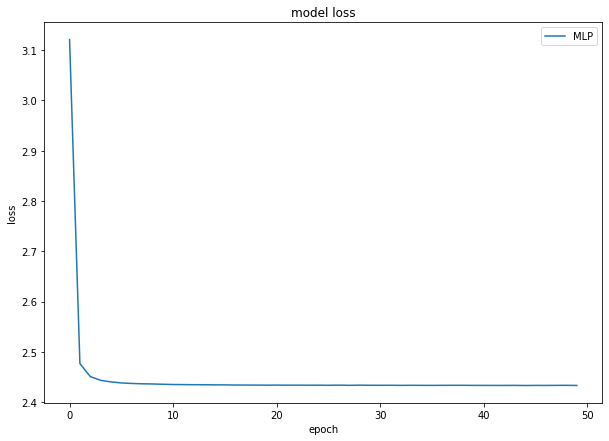

In [ ]:
# history.history.keys()
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
plt.plot(history_mlp.history['loss'], label = "MLP")
plt.legend()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch');

### Test the model.

In [ ]:
mlp_pred = []
original_test_file_excluding_last_two_chars = [] 
states = None


for i in original_test_file:
    
    original_test_file_excluding_last_two_chars.append(i[:-2])

    # next_char = tf.constant([i[:-2]])
    # result = [next_char]

    # for j in range(2):

    #     next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    #     result.append(next_char)   

    # mlp_pred.append( tf.strings.join(result)[0].numpy().decode("utf-8") ) 

In [ ]:
mlp_pred

['Biographice\r',
 'Wheelbarr n',
 'Nightgore',
 'Counterpasi',
 'Christm h',
 'Squirin',
 'Specksnyd s',
 'Forecaste\r',
 'Affidave\r',
 'Hyeng',
 'Monstroo ',
 'Town-be',
 'Massack\r',
 'Funer, ',
 'Battering-R m']

In [ ]:
original_test_file_excluding_last_two_chars

['Biographic',
 'Wheelbarr',
 'Nightgo',
 'Counterpa',
 'Christm',
 'Squir',
 'Specksnyd',
 'Forecast',
 'Affidav',
 'Hye',
 'Monstro',
 'Town-',
 'Massac',
 'Funer',
 'Battering-R']

# LSTM

## Build The Model

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModelLSTM2(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    # if states is None:
    #   states = self.gru.get_initial_state(x)
    x, states, _ = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states, _
    else:
      return x

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Dense, LSTM

# # Define the Keras model
# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim))
# model.add(LSTM(rnn_units))
# model.add(Dense(vocab_size))

In [ ]:
model = MyModelLSTM2(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## Try the model

<!-- Now run the model to see that it behaves as expected.

First check the shape of the output: -->

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 96) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model_lstm2_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    multiple                  24576     
                                                                 
 lstm_14 (LSTM)              multiple                  5246976   
                                                                 
 dense_20 (Dense)            multiple                  98400     
                                                                 
Total params: 5,369,952
Trainable params: 5,369,952
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [ ]:
sampled_indices

array([25, 71, 61, 51, 22, 90,  3, 30, 85, 73, 66, 21, 52, 25, 31, 84, 35,
       78, 93, 81, 48,  1, 66, 77, 29,  8, 92, 65, 70, 77,  9, 63, 76, 32,
       73, 13, 59, 33, 38, 75,  1, 74, 95, 74, 14, 28, 41, 17, 67,  9, 42,
       31, 14, 59, 52, 21, 27, 45, 48, 14,  4, 74, 70,  6, 42, 44, 59, 25,
       67,  4, 38, 55, 46, 48, 13, 67, 77, 26, 21, 22, 84, 21, 37, 83,  5,
       25,  1, 44, 52, 15,  8, 51, 69, 59, 80, 21, 47, 54, 40, 10])

Decode these to see the text predicted by this untrained model:

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'moving. The cabin entrance was locked within; the\r\nhatches were all on, and lumbered with coils of r'

Next Char Predictions:
 b'8mcV5\xc5\x93 A\xc2\xa3oh4W8BzFt\xe2\x80\x99wS\nhs?&\xe2\x80\x98gls\'erCo,aDIq\np\xe2\x80\x9dp-;L0i\'MB-aW4:PS-!pl$MOa8i!IZQS,is945z4Hy"8\nOW.&Vkav4RYK('


## Train the model

### Attach an optimizer, and a loss function

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 96)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.564588, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

96.02303

In [ ]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

`tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_lstm2'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

In [ ]:
EPOCHS = 50

In [ ]:
history_lstm = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/50
193/193 [==============================] - 15s 67ms/step - loss: 2.7023
Epoch 2/50
193/193 [==============================] - 14s 69ms/step - loss: 2.1192
Epoch 3/50
193/193 [==============================] - 15s 72ms/step - loss: 1.8806
Epoch 4/50
193/193 [==============================] - 15s 70ms/step - loss: 1.7273
Epoch 5/50
193/193 [==============================] - 14s 69ms/step - loss: 1.6223
Epoch 6/50
193/193 [==============================] - 14s 69ms/step - loss: 1.5484
Epoch 7/50
193/193 [==============================] - 14s 69ms/step - loss: 1.4895
Epoch 8/50
193/193 [==============================] - 14s 69ms/step - loss: 1.4410
Epoch 9/50
193/193 [==============================] - 15s 71ms/step - loss: 1.4014
Epoch 10/50
193/193 [==============================] - 15s 70ms/step - loss: 1.3683
Epoch 11/50
193/193 [==============================] - 14s 69ms/step - loss: 1.3384
Epoch 12/50
193/193 [==============================] - 14s 69ms/step - loss: 1.3111
E

## Generate text

The following makes a single step prediction:

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['Gabriel '])
result = [next_char]

for n in range(100):
  next_char, states, _ = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
# print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
# print('\nRun time:', end - start)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['Gabriel ', 'Gabriel ', 'Gabriel ', 'Gabriel ', 'Gabriel '])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

## Export the generator


In [ ]:
tf.saved_model.save(one_step_model, 'one_step_lstm2')
one_step_reloaded = tf.saved_model.load('one_step_lstm2')

In [ ]:
states = None
next_char = tf.constant(['Gabriel '])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

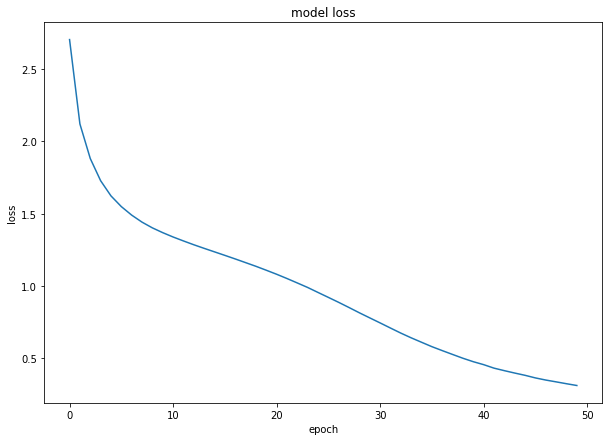

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(history_lstm.history['loss'], label = "LSTM")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch');

### Test the model.

In [ ]:
lstm_pred = []
original_test_file_excluding_last_two_chars = [] 
states = None


for i in original_test_file:
    
    original_test_file_excluding_last_two_chars.append(i[:-2])

    next_char = tf.constant([i[:-2]])
    result = [next_char]

    for j in range(2):

        next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
        result.append(next_char)   

    lstm_pred.append( tf.strings.join(result)[0].numpy().decode("utf-8") ) 

In [ ]:
# lstm_pred

## Aggregate Output

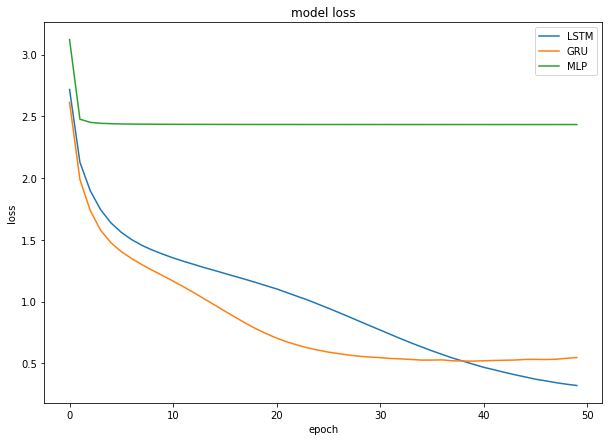

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(history_lstm.history['loss'], label = "LSTM")
plt.plot(history.history['loss'], label = "GRU")
plt.plot(history_mlp.history['loss'], label = "MLP")
plt.title('model loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch');

In [ ]:
model_outcomes = [original_test_file, original_test_file_excluding_last_two_chars,
                 mlp_pred, gru_pred]
df = pd.DataFrame (model_outcomes).transpose()
df.columns = ['Original Chars', 'Original Chars Excluding Last Two Letters',
               'MLP', 'GRU']
df

,Original Chars,Original Chars Excluding Last Two Letters,MLP,GRU
0,Biographical,Biographic,Biographice\r,Biographical
1,Wheelbarrow,Wheelbarr,Wheelbarr n,Wheelbarrow
2,Nightgown,Nightgo,Nightgore,"Nightgo,"
3,Counterpane,Counterpa,Counterpasi,Counterpane
4,Christmas,Christm,Christm h,Christmat
5,Squires,Squir,Squirin,"Squir,\r"
6,Specksnyder,Specksnyd,Specksnyd s,Specksnydly
7,Forecastle,Forecast,Forecaste\r,Forecast l
8,Affidavit,Affidav,Affidave\r,Affidavis
9,Hyena,Hye,Hyeng,Hyers
